# **Importing Data and Modules**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler #preprocess numeric variables
import os #to get file directory

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

#importing libraries for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

#Hierarchial Clustering of Features
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import combinations

#Importing libraries for Multi-layer Perceptron Regression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB


In [2]:
current_dir = os.getcwd()
coffee_df = pd.read_csv(f'{current_dir}/arabica_ratings_raw.csv')
print(f"The dataframe has {coffee_df.shape[0]} rows and {coffee_df.shape[1]} columns")
display(coffee_df.head())

The dataframe has 1312 rows and 53 columns


,Unnamed: 0,quality_score,view_certificate_1,view_certificate_2,Cupping Protocol and Descriptors,View Green Analysis Details,Request a Sample,Species,Owner,Country of Origin,...,Quakers,Color,Category Two Defects,NA.3,Expiration,Certification Body,Certification Address,Certification Contact,Unnamed: 51,Notes
0,0,90.58,NaN,NaN,NaN,NaN,NaN,Arabica,metad plc,Ethiopia,...,0.0,Green,0 full defects,NaN,"April 3rd, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, E...","Aman Adinew (Emebet Dinku) - +251-116-292534, ...",NaN,NaN
1,1,89.92,NaN,NaN,NaN,NaN,NaN,Arabica,metad plc,Ethiopia,...,0.0,Green,1 full defects,NaN,"April 3rd, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, E...","Aman Adinew (Emebet Dinku) - +251-116-292534, ...",NaN,NaN
2,2,89.75,NaN,NaN,NaN,NaN,NaN,Arabica,Grounds for Health Admin,Guatemala,...,0.0,NaN,0 full defects,NaN,"May 31st, 2011",Specialty Coffee Association,"117 W 4th St, Suite 300 Santa Ana, CA 92701",Chris Buck - (562) 624-4100,NaN,NaN
3,3,89.00,NaN,NaN,NaN,NaN,NaN,Arabica,Yidnekachew Dabessa,Ethiopia,...,0.0,Green,2 full defects,NaN,"March 25th, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, E...","Aman Adinew (Emebet Dinku) - +251-116-292534, ...",NaN,NaN
4,4,88.83,NaN,NaN,NaN,NaN,NaN,Arabica,metad plc,Ethiopia,...,0.0,Green,2 full defects,NaN,"April 3rd, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, E...","Aman Adinew (Emebet Dinku) - +251-116-292534, ...",NaN,NaN


# **Data Cleaning**

### Dealing with Missing Values

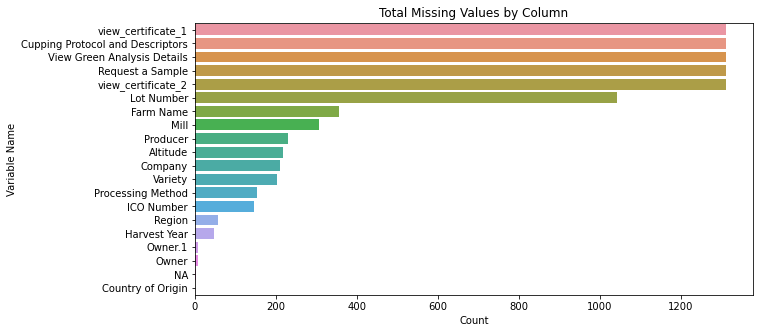

In [3]:
#only showing top 20 to make the plot more legible 
missing_values_by_column = coffee_df.isna().sum()[(coffee_df.isna().sum() > 0)][0:20].sort_values(ascending = False) #summing null values per column

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_values_by_column.values, y=missing_values_by_column.index)
plt.xlabel("Count")
plt.ylabel("Variable Name")
plt.title("Total Missing Values by Column")
plt.show()

coffee_df = coffee_df.dropna(axis = 1,thresh = 1000) #removed all columns with over 1000 missing values

Many columns had too many missing values to use for predicting the quality score. Since there are only 1312 rows in the dataset, we have dropped the columns that have more than 1000 missing values since they will clearly not be useful to predict the quality score. There are still many columns with over 200 missing values but for now we will just take note and reconsider removing them to improve model performance and simplicity.

In [4]:
print("Column Species has unique value: " + coffee_df['Species'].unique()[0])
print("Column Status has unique value: " + coffee_df['Status'].unique()[0])
print("Number of unique values in categorical variable Altitude: " + str(len(coffee_df['Altitude'].unique())))
print("Number of non zero values in column Quakers: " + str(coffee_df['Quakers'].loc[coffee_df['Quakers'] != 0].count()))

Column Species has unique value: Arabica
Column Status has unique value: Completed
Number of unique values in categorical variable Altitude: 408
Number of non zero values in column Quakers: 94


Species: Only contains "Arabica" thus will not be a useful column.

Status: Only contains "Completed", similar to the Species column, this will not be a useful column.

Altitude: 408 unique values in inconsistent formats (meters, feet, yards, unlabeled). This column may be an influential predictor but it is too hard to clean to make it useful. Unfortunately we have to drop it.

Quakers: Only 94 rows that are non zero. Since the data is very limited, we should drop this column.

In [5]:
coffee_df = coffee_df.drop(['Owner','Mill','ICO Number','Company','Expiration','Certification Body','Certification Address','Certification Contact','In-Country Partner','Bag Weight','Number of Bags','Producer','Harvest Year','Grading Date','Owner.1','Variety','NA.1','Unnamed: 0','Region','Status','NA','Altitude','Quakers','Species'],axis = 1)

There are many columns that either do not seem important or are non descriptive. We are dropping them because they won't be useful for predicting the quality of coffee beans.

Dropped Columns: 

Owner, Mill, ICO Number, Company, Expiration, Certification Body, Certification Address, Certification Contact, In-Country Partner, Bag Weight, Number of Bags, Producer, Harvest Year, Grading Date, Owner.1, Variety, NA.1, Unnamed: 0, Region, Status, NA, Altitude, Quakers, Species

In [6]:
print("Before Manipulating Strings and converting the columns to floats")
display(coffee_df[["Total Cup Points","Moisture","Category One Defects","Category Two Defects"]].head())

coffee_df['Total Cup Points'] = coffee_df['Total Cup Points'].str.extract('Sample(.*)').astype('float64')
coffee_df['Moisture'] = coffee_df['Moisture'].str.extract('(.*) %').astype('float64')
coffee_df['Category One Defects'] = coffee_df['Category One Defects'].str.extract('(.*) full defects').astype('float64')
coffee_df['Category Two Defects'] = coffee_df['Category Two Defects'].str.extract('(.*) full defects').astype('float64')
# Truncated string portions of each column and converted to float data type

print("After Manipulating Strings and converting the columns to floats")
display(coffee_df[["Total Cup Points","Moisture","Category One Defects","Category Two Defects"]].head())


Before Manipulating Strings and converting the columns to floats


,Total Cup Points,Moisture,Category One Defects,Category Two Defects
0,Sample 90.58,12 %,0 full defects,0 full defects
1,Sample 89.92,12 %,0 full defects,1 full defects
2,Sample 89.75,0 %,0 full defects,0 full defects
3,Sample 89.00,11 %,0 full defects,2 full defects
4,Sample 88.83,12 %,0 full defects,2 full defects


After Manipulating Strings and converting the columns to floats


,Total Cup Points,Moisture,Category One Defects,Category Two Defects
0,90.58,12.0,0.0,0.0
1,89.92,12.0,0.0,1.0
2,89.75,0.0,0.0,0.0
3,89.00,11.0,0.0,2.0
4,88.83,12.0,0.0,2.0


In [7]:
display(coffee_df.loc[coffee_df['Country of Origin'].isna()])

,quality_score,Country of Origin,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Total Cup Points,Moisture,Category One Defects,Color,Category Two Defects
1197,79.08,NaN,NaN,6.75,6.75,6.42,6.83,7.58,7.5,10.0,10.0,10.0,7.25,79.08,10.0,0.0,NaN,3.0


We manually checked the only null row for Country of Origin incase there is any problems. After checking the We choose not to remove this row even though its the only row with a null value. It could be a good data point.

In [8]:
print(f"There is {coffee_df['quality_score'].where(coffee_df['quality_score'] == 0).count()} example where the quality score is 0")
print("\n")
print(coffee_df.loc[1311])

coffee_df = coffee_df.drop(1311)

There is 1 example where the quality score is 0


quality_score                0.0
Country of Origin       Honduras
Processing Method            NaN
Aroma                        0.0
Flavor                       0.0
Aftertaste                   0.0
Acidity                      0.0
Body                         0.0
Balance                      0.0
Uniformity                   0.0
Clean Cup                    0.0
Sweetness                    0.0
Cupper Points                0.0
Total Cup Points             0.0
Moisture                    12.0
Category One Defects         0.0
Color                      Green
Category Two Defects         2.0
Name: 1311, dtype: object


There seems to be something wrong with this row as most the values are defaulted to 0. For this reason, we have manually dropped this row.

### **Exploratory Data Analysis**

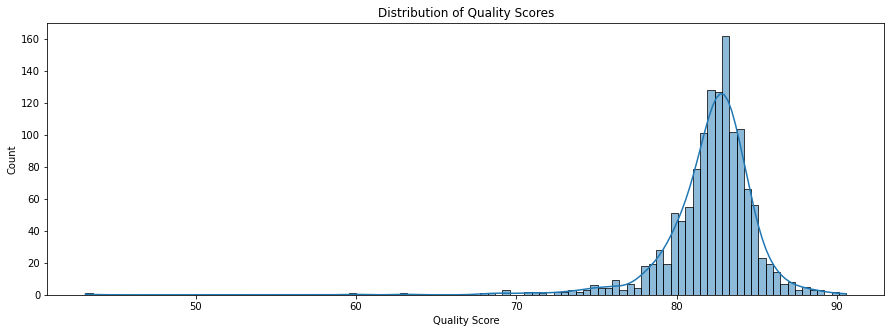

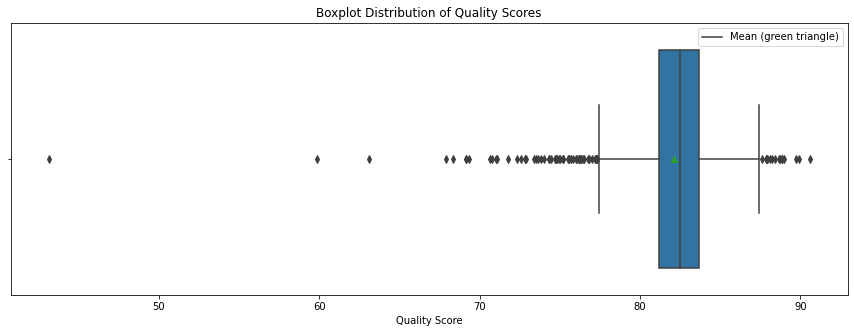

In [9]:
plt.figure(figsize=(15, 5))
sns.histplot(coffee_df['quality_score'],kde=True)
plt.xlabel("Quality Score")
plt.title("Distribution of Quality Scores")
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(data = coffee_df, x = 'quality_score', showmeans = True)
plt.xlabel("Quality Score")
plt.title("Boxplot Distribution of Quality Scores")
plt.legend(["Mean (green triangle)"])

plt.show()

The distribution of quality scores follows a normal bell curve shape with a mean and median relatively close together around 85. We can see there is a clear outlier with a quality score of 43 and several more values outside the whiskers on the boxplot. This is especially true on the lower side because quality score has a definitive range between 0 and 100.

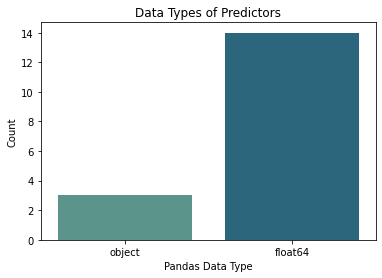

In [10]:
#There are 3 categorical variables and 15 numerical variables
sns.countplot(x=coffee_df.drop(columns = ['quality_score']).dtypes.astype(str), palette='crest')

plt.title("Data Types of Predictors")
plt.xlabel("Pandas Data Type")
plt.ylabel("Count")
plt.show()

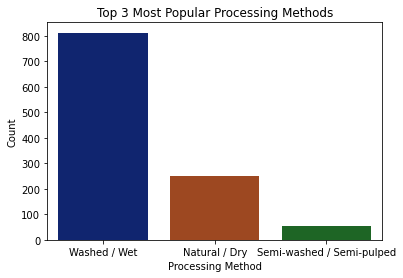

In [11]:
#There are hardly any coffee beans that are Semi-washed/ Semi-pulped in the dataset.
sns.countplot(x='Processing Method', data=coffee_df, order=coffee_df['Processing Method'].value_counts().index[:3], palette = "dark")
plt.title("Top 3 Most Popular Processing Methods")
plt.xlabel("Processing Method")
plt.ylabel("Count")
plt.show()

Compare the avarage Quality score by processig Method 

Processing Method
Pulped natural / honey       82.807857
Semi-washed / Semi-pulped    82.633571
Natural / Dry                82.354143
Washed / Wet                 81.964618
Name: quality_score, dtype: float64


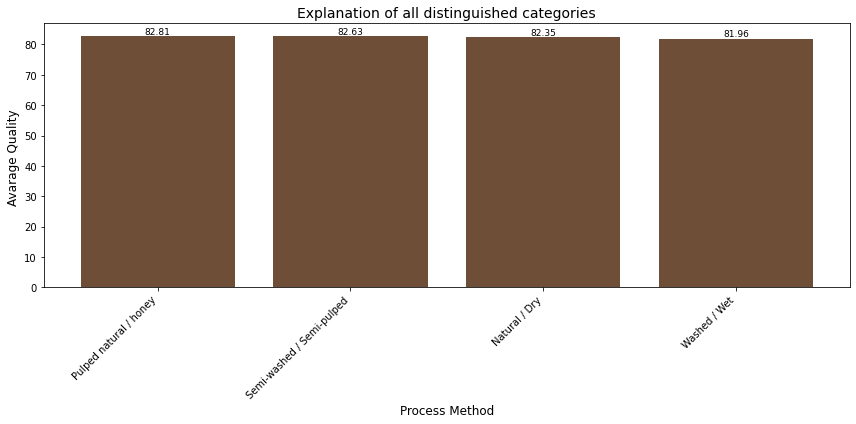

In [12]:
process_quality = (
    coffee_df[coffee_df["Processing Method"] != "Other"]
    .groupby("Processing Method")["quality_score"]
    .mean()
    .sort_values(ascending=False)
)
print(process_quality)
plt.figure(figsize=(12,6))
bars = plt.bar(process_quality.index, process_quality.values, color='#6F4E37')
plt.title("Explanation of all distinguished categories", fontsize=14)
plt.xlabel("Process Method", fontsize=12)
plt.ylabel("Avarage Quality ", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Visualize how each key attribute relates to the overall coffee quality.

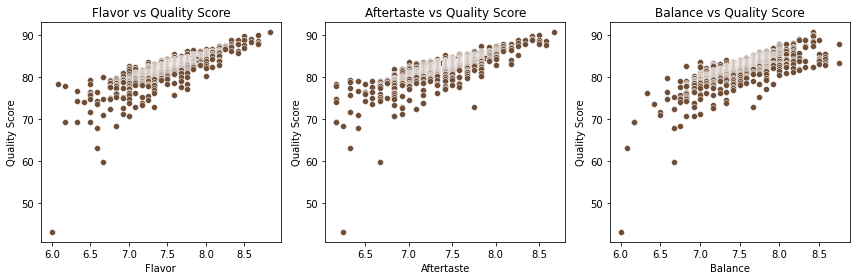

In [13]:
features_EDA = ["Flavor", "Aftertaste", "Balance"]
plt.figure(figsize=(12,4))
for i, feature in enumerate(features_EDA):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=coffee_df, x=feature, y="quality_score", color="#6F4E37")
    plt.title(f"{feature} vs Quality Score")
    plt.xlabel(feature)
    plt.ylabel("Quality Score")

plt.tight_layout()
plt.show()

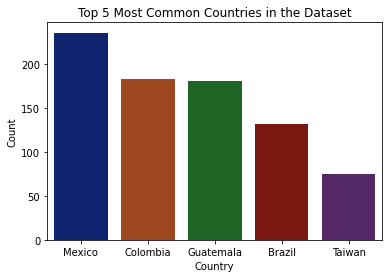

In [14]:
#We can see that most the Arabica beans from the dataset comes from Mexico and South American countries. 
sns.countplot(x='Country of Origin', data=coffee_df, order=coffee_df['Country of Origin'].value_counts().index[:5], palette = "dark")
plt.title("Top 5 Most Common Countries in the Dataset")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

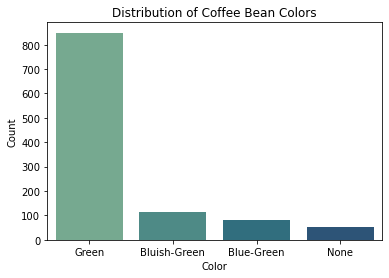

In [15]:
#By far most the coffee beans are green.
sns.countplot(x='Color', data=coffee_df, palette='crest',order=coffee_df['Color'].value_counts().index)
plt.title("Distribution of Coffee Bean Colors")
plt.xlabel("Color")
plt.ylabel("Count")
plt.show()

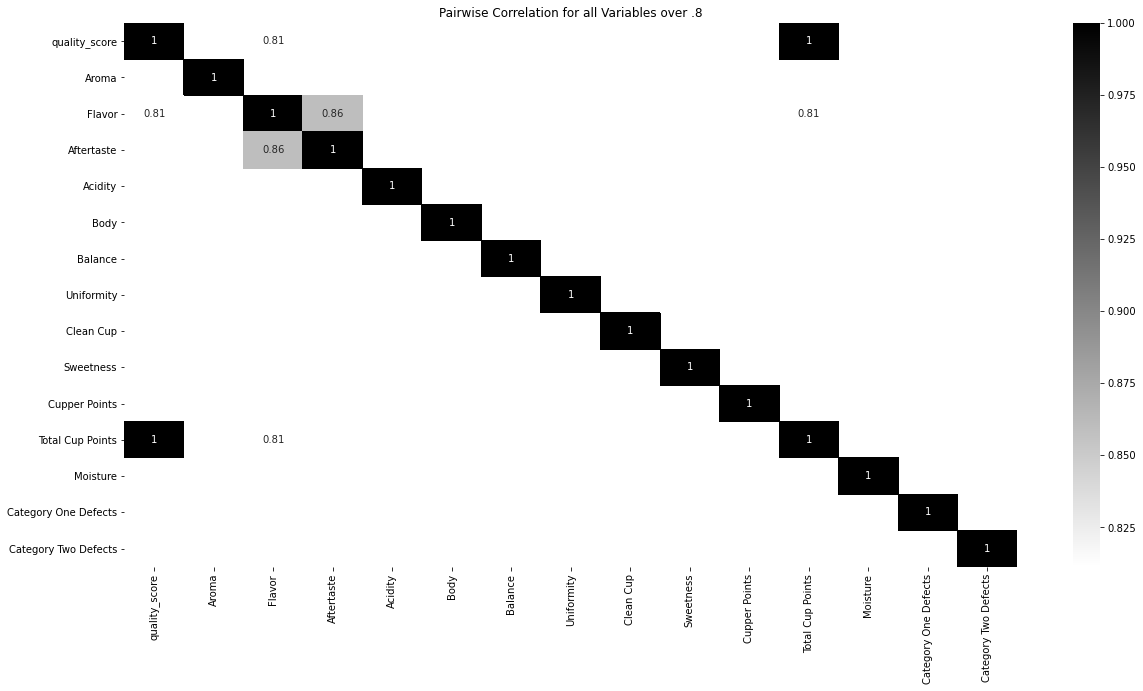

In [16]:
plt.figure(figsize=(20, 10))
corr_matrix = sns.heatmap(coffee_df.corr()[coffee_df.corr() > .8], annot = True, cmap = 'binary');
corr_matrix.set(title = 'Pairwise Correlation for all Variables over .8');
plt.show(corr_matrix);

We can see that Total Cup Points and Quality Score has a correlation coefficient of 1. This means they are probably calculated from one another. For this reason, we can safely drop Total Cup Points as a column.

We can expect Flavor, Aftertaste, and Balance to be highly impactful variables since they are highly positively correllated to the quality score. 

To avoid multicollinearity, we should consider dropping the column for flavor as it is highly correlated with 4 other predictors. 

# Preprocessing data

### Normalizing numeric variables using MinMaxScaler from sklearn

In [17]:
numeric_variables = ['Aroma','Flavor','Aftertaste','Acidity','Body','Balance','Uniformity','Clean Cup','Sweetness','Cupper Points']
scaler = StandardScaler()
scaler.fit_transform(coffee_df[numeric_variables])
coffee_df[numeric_variables] = scaler.transform(coffee_df[numeric_variables])

We normalized the numeric variables by using MinMaxScaler, scaling the range of all the numeric variables between 0 and 1.

### **Train the baseline model. ( Linear Regression & Decision Tree) to predict coffee Quality**

In [18]:
X = coffee_df[numeric_variables]
y = coffee_df['quality_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("LR Results:")
print(f"MSE: {lr_mse:.4f}")
print(f"R² Score: {lr_r2:.4f}\n")

#Decision Tree 
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

print("DT Results:")
print(f"MSE: {dt_mse:.4f}")
print(f"R² Score: {dt_r2:.4f}")


LR Results:
MSE: 0.0010
R² Score: 0.9998

DT Results:
MSE: 0.6714
R² Score: 0.8926


In [20]:
df_class = coffee_df.copy()
def categorize_quality(score):
    if score >= 87:
        return "High"
    elif score >= 85:
        return "Medium"
    else:
        return "Low"
df_class["Quality_Label"] = df_class["quality_score"].apply(categorize_quality)

print(df_class["Quality_Label"].value_counts())
df_class.head()

Low       1205
Medium      81
High        25
Name: Quality_Label, dtype: int64


,quality_score,Country of Origin,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Total Cup Points,Moisture,Category One Defects,Color,Category Two Defects,Quality_Label
0,90.58,Ethiopia,Washed / Wet,3.458057,3.798054,3.610727,3.784186,3.304040,2.554083,0.297973,0.216431,0.182289,2.909245,90.58,12.0,0.0,Green,0.0,High
1,89.92,Ethiopia,Washed / Wet,3.709183,3.333230,3.126462,3.253243,3.033687,2.554083,0.297973,0.216431,0.182289,2.512813,89.92,12.0,0.0,Green,1.0,High
2,89.75,Guatemala,NaN,2.673288,2.839355,2.898572,2.753532,2.729540,2.554083,0.297973,0.216431,0.182289,4.075220,89.75,0.0,0.0,NaN,0.0,High
3,89.00,Ethiopia,Natural / Dry,1.888520,3.071767,2.898572,2.753532,3.304040,2.070526,0.297973,0.216431,0.182289,2.722689,89.00,11.0,0.0,Green,2.0,High
4,88.83,Ethiopia,Washed / Wet,2.139646,2.839355,2.414307,3.003387,3.033687,2.298082,0.297973,0.216431,0.182289,2.512813,88.83,12.0,0.0,Green,2.0,High


In [21]:
# َQuality Decision Tree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Features Sellection
y = df_class["Quality_Label"]

#80% Train 20% Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Train The Model
clf = DecisionTreeClassifier(max_depth=5, random_state=42)  
clf.fit(X_train, y_train)
# Make Predictions
y_pred = clf.predict(X_test)
#Evaluate The Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

print("Classification :\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.96

Classification :

              precision    recall  f1-score   support

        High       0.80      0.80      0.80         5
         Low       0.98      0.99      0.98       242
      Medium       0.71      0.62      0.67        16

    accuracy                           0.96       263
   macro avg       0.83      0.80      0.82       263
weighted avg       0.96      0.96      0.96       263



<AxesSubplot:>

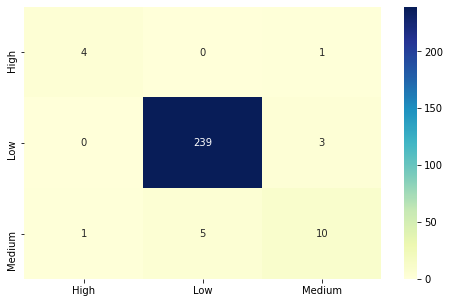

In [22]:
#Matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
    cmap="YlGnBu",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)

KNN Accuracy: 0.98
Naive Bayes Accuracy: 0.90


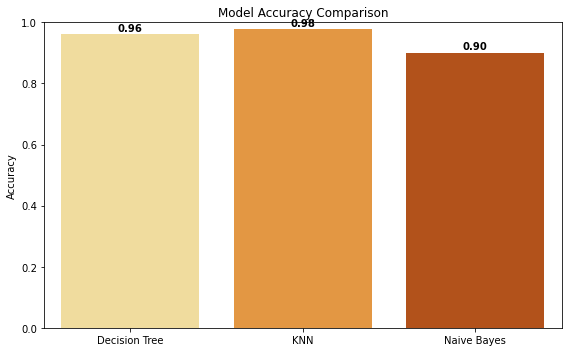

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# ===============================
# K-Nearest Neighbours (KNN)
# ===============================
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune k later
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print(f"KNN Accuracy: {knn_acc:.2f}")

# ===============================
# Naive Bayes
# ===============================
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)
print(f"Naive Bayes Accuracy: {nb_acc:.2f}")

# ===============================
# Compare All Models
# ===============================
models = ["Decision Tree", "KNN", "Naive Bayes"]
accuracies = [accuracy, knn_acc, nb_acc]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="YlOrBr")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

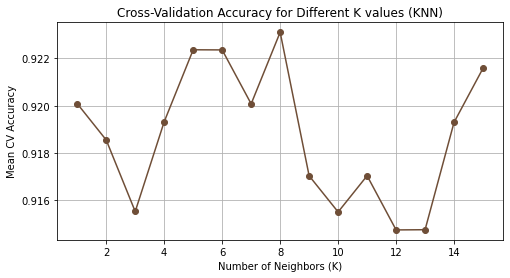

Best K value based on cross-validation: 8


In [24]:
from sklearn.model_selection import cross_val_score

# Test different values of K
k_values = range(1, 16)
cv_scores_knn = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X, y, cv=5)
    cv_scores_knn.append(scores.mean())

plt.figure(figsize=(8,4))
plt.plot(k_values, cv_scores_knn, marker='o', color='#6F4E37')
plt.title("Cross-Validation Accuracy for Different K values (KNN)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(cv_scores_knn)]
print(f"Best K value based on cross-validation: {best_k}")

Model Performance Analysis

The results show that the K-Nearest Neighbours (KNN) model had the highest accuracy at around 97%. This was just above the Decision Tree model, which reached about 96%. The Naive Bayes classifier had the lowest accuracy at about 84%.

The Naive Bayes model assumes that features are independent, but this is not the case for this dataset. Many sensory attributes are correlated, as shown in the correlation analysis. This explains why Naive Bayes had lower accuracy.

The Decision Tree model also performed well and was easy to interpret. It showed which features, especially Flavor and Balance, were most important for performance. To improve results in the future, it may help to try ensemble methods like Random Forest or Gradient Boosting. Feature scaling and normalization could also make KNN work even better.

# Feature Selection

In [25]:
# X = coffee_df.drop(columns = ['quality_score'],axis = 1)
y = coffee_df["quality_score"]

# clustering for feature evaluation
kmeans = KMeans(n_clusters=3, random_state = 42, n_init = 20)
coffee_df['cluster'] = kmeans.fit_predict(X)


#Cluster Quality Metrics
s_score = silhouette_score(X, coffee_df['cluster'])
db_score = davies_bouldin_score(X, coffee_df['cluster'])
print(f"\nCluster Quality:")
print(f"Silhouette Score     : {s_score:.3f}")
print(f"Davies–Bouldin Index : {db_score:.3f}")


Cluster Quality:
Silhouette Score     : 0.300
Davies–Bouldin Index : 1.154


In [26]:
#dimensionality reduction and visualisation 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

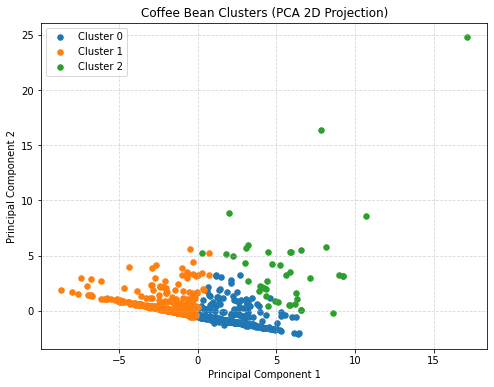

In [27]:
plt.figure(figsize=(8,6))
for c in np.unique(coffee_df['cluster']):
    plt.scatter(X_pca[coffee_df['cluster']==c, 0],
                X_pca[coffee_df['cluster']==c, 1],
                label=f"Cluster {c}", s=30)
plt.title("Coffee Bean Clusters (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [28]:
#inter-cluster Variance
feature_variance = coffee_df.groupby('cluster')[numeric_variables].mean().var().sort_values(ascending=False)
print("\nFeature variance across clusters:")
display(feature_variance)


Feature variance across clusters:


Clean Cup        6.119640
Uniformity       2.556011
Sweetness        1.985676
Flavor           1.705316
Aftertaste       1.693436
Balance          1.586376
Cupper Points    1.470224
Aroma            1.081433
Acidity          0.888149
Body             0.835634
dtype: float64

In [29]:
top_features = feature_variance.head(5).index.tolist()
print(f"Top discriminative features: {top_features}")

Top discriminative features: ['Clean Cup', 'Uniformity', 'Sweetness', 'Flavor', 'Aftertaste']


In [30]:
corr = coffee_df[numeric_variables].corr().abs()
Z = linkage(1 - corr, method='average')

<ipython-input-30-54397c4fe77e>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - corr, method='average')


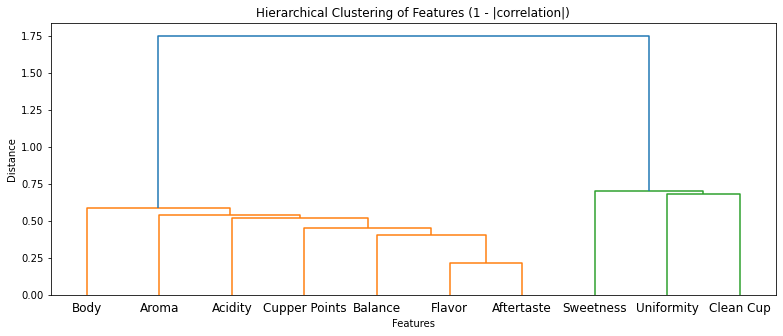

In [31]:
plt.figure(figsize=(13,5))
dendrogram(Z, labels=numeric_variables)
plt.title("Hierarchical Clustering of Features (1 - |correlation|)")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

In [32]:
#Evaluating Features
best_score = -1
best_subset = None
for r in range(5, len(numeric_variables)+1):
    for subset in combinations(numeric_variables, r):
        X_sub = scaler.fit_transform(coffee_df[list(subset)])
        labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(X_sub)
        score = silhouette_score(X_sub, labels)
        if score > best_score:
            best_score = score
            best_subset = subset

In [33]:
print(f"\nBest feature subset by Silhouette Score ({best_score:.4f}):")
print(best_subset)



Best feature subset by Silhouette Score (0.3824):
('Flavor', 'Aftertaste', 'Balance', 'Uniformity', 'Sweetness')


In [34]:
#preparing final dataset with selected features
selected_features = list(best_subset)
X = pd.concat([coffee_df[numeric_variables],pd.get_dummies(coffee_df['cluster'], prefix='cluster', drop_first=True)], axis=1)
y = coffee_df['quality_score']


# Neural Network

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
#Training Model
model = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', early_stopping=True, random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Evaluating Regression performance
rmse_MLP = np.sqrt(mean_squared_error(y_test, y_pred))
mae_MLP = mean_absolute_error(y_test, y_pred)
r2_MLP = r2_score(y_test, y_pred)

print(f"\nRegression Performance (MLP + Cluster Features):")
print(f"Mean Squared Error: {rmse_MLP}")
# print(f"Mean Absolute Error : {mae}")
print(f"R_square  : {r2_MLP}")


Regression Performance (MLP + Cluster Features):
Mean Squared Error: 0.842347752631349
R_square  : 0.8865019822793287


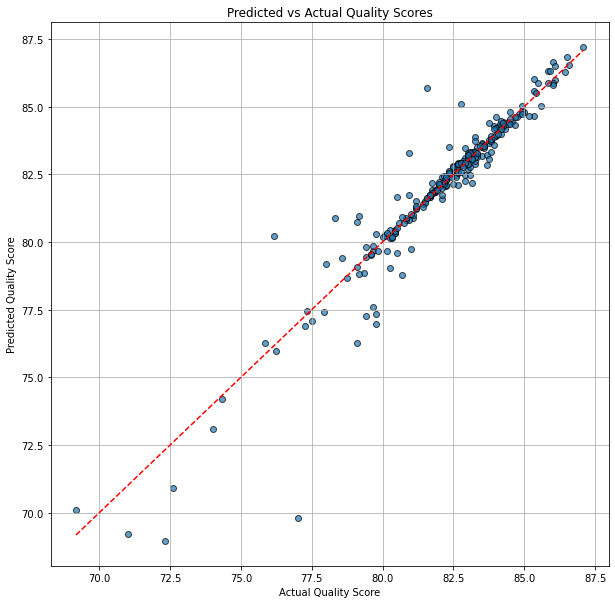

In [37]:
#predicted vs Actual scores
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Quality Scores")
plt.xlabel("Actual Quality Score")
plt.ylabel("Predicted Quality Score")
plt.grid(True)
plt.show()

In [38]:
#Evaluating Regression performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [39]:
#Relative Accuracy
relative_accuracy = (1 - mae / np.mean(y_test)) * 100
print(f"Approx. Accuracy   : {relative_accuracy:.2f}%")

Approx. Accuracy   : 99.53%
